In [1]:
import os
import pandas as pd
import numpy as np
import math
import itertools
from matplotlib import pyplot as plt
from datetime import datetime
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

%matplotlib inline
import torch
from torch import nn, optim

In [2]:
df = pd.read_csv('MVIS_out.csv')
df = df.rename(columns={'MVIS': 'Stock'})
df.head(5)

,Stock,positive,neutral,negative
0,7.24,NaN,NaN,NaN
1,7.11,NaN,NaN,NaN
2,7.37,NaN,NaN,NaN
3,7.63,NaN,NaN,NaN
4,9.26,NaN,NaN,NaN


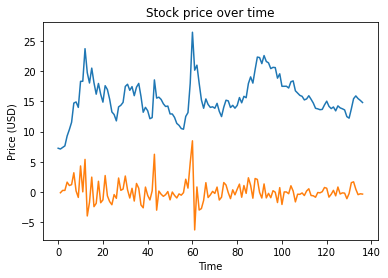

In [3]:
plt.plot(df.Stock)
plt.plot(df.Stock.diff(1),label="difference")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Stock price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show()

In [4]:
X, y = df.drop(columns=['Stock']), df.Stock.values
X.shape, y.shape

((137, 3), (137,))

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

dataset = np.hstack((X_trans,y_trans))

In [6]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)


total_samples = len(X)
train_test_cutoff = round(0.80 * total_samples)

data_window = 10
predict_window = 5
tot_window = data_window  + predict_window


X_ss, y_mm = split_sequences(X_trans, y_trans, data_window, predict_window)
print(X_ss.shape, y_mm.shape)

(124, 10, 3) (124, 5)


In [7]:
X_train = X_ss[:-tot_window]
X_test = X_ss[-tot_window:]

y_train = y_mm[:-tot_window]
y_test = y_mm[-tot_window:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (109, 10, 3) (109, 5)
Testing Shape: (15, 10, 3) (15, 5)


In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable

X_train = np.where(np.isnan(X_train), 0, X_train)
y_train = np.where(np.isnan(y_train), 0, y_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_test = np.where(np.isnan(y_test), 0, y_test)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [9]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0],data_window, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], data_window, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([109, 10, 3]) torch.Size([109, 5])
Testing Shape: torch.Size([15, 10, 3]) torch.Size([15, 5])


In [71]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)#, dropout=0.2) # lstm
        #self.lstm = nn.LSTM(input_size=input_size, num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.fc_3 = nn.Linear(10, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        #h_0 = Variable(torch.rand(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        #c_0 = Variable(torch.rand(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        #output, (hn, cn) = self.lstm(x) #, (h_0, c_0)) # (input, hidden, and internal state)
        print("my x in is ")
        print(x)
        output,_ = self.lstm(x)#, (h_0, c_0)) #, (h_0, c_0)) # (input, hidden, and internal state)
        print(" my output shape is ")
        print(output.shape)
        print(" my linear layer looks like ")
        print(self.fc_3)
        #hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        #out = self.relu(hn)
        #out = self.fc_1(out) # first dense
        #out = self.relu(out) # relu
        #out = self.fc_2(out) # final output
        out = self.fc_3(10,output)
        return out

In [80]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))

In [81]:
n_epochs = 2000 # 1000 epochs
learning_rate = 0.0001 # 0.001 lr

input_size = 3 # number of features
hidden_size = 1 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = predict_window # number of output classes 

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [82]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.0001) #, momentum=0.9)

In [83]:
training_loop(n_epochs=n_epochs, lstm=lstm, 
              optimiser=optimiser,
              loss_fn=loss_fn, 
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

my x in is 
tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [ 2.1323,  0.0074, -0.3413],
         [ 1.1372, -0.5200, -0.3413],
         [ 2.3919, -0.6179, -0.3413]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [ 1.1372, -0.5200, -0.3413],
         [ 2.3919, -0.6179, -0.3413],
         [ 1.3535, -0.4748, -0.3413]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [ 2.3919, -0.6179, -0.3413],
         [ 1.3535, -0.4748, -0.3413],
         [ 1.9448, -0.7083, -0.3413]],

        ...,

        [[ 0.0989, -0.7158, -0.3413],
         [ 1.5410, -0.7158, -0.3413],
         [ 0.9065, -0.7158, -0.3413],
         ...,
         [-0.6222, -0.4597, -0.3413],
         [-0.3193, -0.3015, -0.3413],
         [ 0.4594, -0.7158, -0.3413]],

TypeError: forward() takes 2 positional arguments but 3 were given

In [79]:
df_X_ss = ss.transform(df.drop(columns=['Stock'])) # old transformers
df_y_mm = mm.transform(df.Stock.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, data_window, predict_window)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], data_window, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

# take difference from day+1 to today, see if dirrection matches
true_diff = np.diff(true)
preds_diff = np.diff(preds)


plt.plot(true, label='Actual Data',c='k') # actual plot
plt.plot(preds, label='Predicted Data',c='r') # predicted plot
print(preds)
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

plt.plot(true_diff, label='Actual Data Diff.',c='k') # actual plot
plt.plot(preds_diff, label='Predicted Data Diff.',c='r') # predicted plot

forecast = []
for ii, ele in enumerate(true_diff):
    forecast_direction = -1
    if ele>0 and preds_diff[ii]>0:
        forecast_direction=1
    elif ele<0 and preds_diff[ii]<0:
        forecast_direction=1
    else:
        forecast_direction=0
    forecast.append(forecast_direction)

print(forecast)
tot_agree = sum(forecast)
print(tot_agree)
percent_agree = tot_agree/len(forecast)
print(percent_agree)
    
print(preds)
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_diff_plot.png", dpi=300)
plt.show() 

my x in is 
tensor([[[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [ 2.1323e+00,  7.4004e-03, -3.4134e-01],
         [ 1.1372e+00, -5.1996e-01, -3.4134e-01],
         [ 2.3919e+00, -6.1790e-01, -3.4134e-01]],

        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [ 1.1372e+00, -5.1996e-01, -3.4134e-01],
         [ 2.3919e+00, -6.1790e-01, -3.4134e-01],
         [ 1.3535e+00, -4.7476e-01, -3.4134e-01]],

        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [ 2.3919e+00, -6.1790e-01, -3.4134e-01],
         [ 1.3535e+00, -4.7476e-01, -3.4134e-01],
         [ 1.9448e+00, -7.0830e-01, -3.4134e-01]],

        ...,

        [[        nan,    

TypeError: forward() takes 2 positional arguments but 3 were given

[14.968549728393555, 14.366002082824707, 13.70756721496582, 13.4052734375, 13.008726119995117]


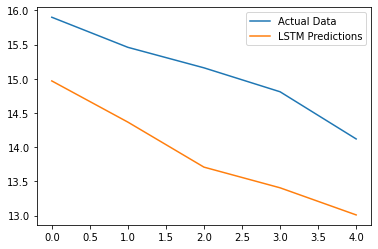

In [333]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

print(test_predict)

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.legend()
plt.show();

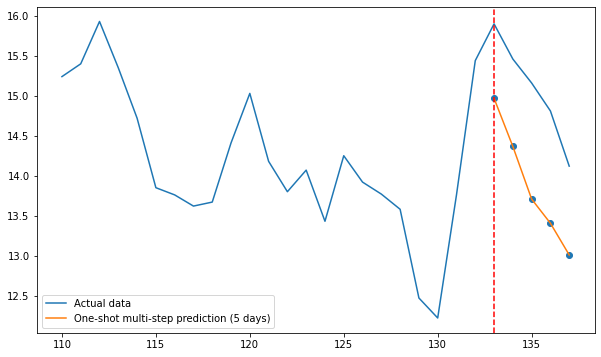

In [334]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(X_train_tensors_final.shape[0], len(y))]
plt.plot(a, y[X_train_tensors_final.shape[0]:], label='Actual data');
c = [x for x in range(len(y)-predict_window, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction ({0} days)'.format(predict_window))
plt.scatter(c, test_predict)
plt.axvline(x=len(y)-predict_window, c='r', linestyle='--')
plt.legend()
plt.show()